<h1>CSE483 Computer Vision Major Task</h1>
<h2>Team 1</h2>
<ul>
<li>Youssef George 19p9824</li>
<li>Kerollos Wageeh 19p3468</li>
<li>Nada Amr 19p1621</li>
</ul>

## Import Libraries
- Use "pip install libName" in terminal if any of them is not installed on your machine.

In [1]:
import pandas as pd
import numpy as np
import cv2
from scipy.io import loadmat
import json
import statistics
import torch
from torchvision import ops
from operator import itemgetter
import random
import tensorflow as tf
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

------------------------------------------------------------------------------------------------------------------------------

## Custom Function Definitions

- Constants used to modify algorithm

In [2]:
# CONSTANTS
useCONTRAST = 1 
useCLAHE = 0 
useOPEN = 0
useCLOSE = 0
useCANNY = 0 
cannyTH1 = 150 
cannyTH2 = 200 

- Function that imports pictures, labels, boxes from the givin dataset. <br>
&emsp; Only parameter "chosen_set" specifies which folder to import: train / test / extra

In [3]:
# Fn import pics, labels, true boxes
def getPics(chosen_set):
    images = []
    labels = []
    boxes = []
    
    picsFolder_path = "SVHN/" + chosen_set + "/"
    with open(picsFolder_path + 'digitStruct.json') as f:
        data = json.load(f)

# import colored pictures
    for i in range(len(data)):
        image = cv2.imread(picsFolder_path + data[i]['filename'])
        images.append(image)
        temp=[]
        for j in range(len(data[i]['boxes'])):
            temp.append(data[i]['boxes'][j]['label'])
        temp = np.array(temp)
        labels.append(temp)
        boxes.append(data[i]['boxes'])

    print("There are ", len(data), " images in " + chosen_set + " set.")
    return images, labels, boxes

In [4]:
train_images_all, train_labels_all, train_boxes_all = getPics("test")

There are  13068  images in test set.


In [5]:
train_images = train_images_all
train_labels = train_labels_all
train_boxes = train_boxes_all

- Function that passes a single image through the built CV pipeline. <br>
&emsp; Returns predicted boxes around recognized contours. 

In [57]:
# Fn performs CV techniques on a single picture
def rectanglesModel(img, bilateral=17):
    image = img.copy()
    boxes = []
    kernel = np.ones((3, 3), np.uint8)

    image = cv2.bilateralFilter(image,11,bilateral,bilateral)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
     
    # image = cv2.GaussianBlur(image, (3, 3),0)
    
    if(useCONTRAST):
        cv2.convertScaleAbs(image, image)
        
    if(useCLAHE):
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image = clahe.apply(image)
    bnr = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,1)
    
    if(useOPEN):
        bnr = cv2.morphologyEx(bnr, cv2.MORPH_OPEN,
                           kernel, iterations=1)
    if(useCLOSE):
        bnr = cv2.morphologyEx(bnr, cv2.MORPH_CLOSE,
                           kernel, iterations=1)
    
    if(useCANNY):
        bnr = cv2.Canny(image, cannyTH1, cannyTH2, 255)
        
    contours, hierarchy = cv2.findContours(bnr, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    
    for i in range(len(contours)):
        boxes.append({})
        x,y,w,h = cv2.boundingRect(contours[i])
        boxes[i]['left'], boxes[i]['top'], boxes[i]['width'], boxes[i]['height'] = x,y,w,h
        twopointsRec = [x,y,x+w,y+h]

    return boxes

------------------------------------------------------------------------------------------------------------------------------

#### Custom Fns to test accuracy

- Function that tests predicted boxes IOU weighted average accuracy against true boxes. <br>
&emsp; Returns accuracy(%) and boxes that match the true boxes.

In [55]:
# IOU average accuracy test per picture
def iouPicTest(truth, predicted, threshold1=0.5, threshold2=0.5): 
    filtered = []
    boxesTensors = []
    # Check IOU of predicted against all true boxes
    for i in range(len(truth)):
        for j in range(len(predicted)):
            truth_box = torch.tensor(
                [[truth[i]['left'], truth[i]['top'], truth[i]['left'] + truth[i]['width'],
                  truth[i]['top']+truth[i]['height']]], dtype=torch.float)
            predicted_box = torch.tensor(
                [[predicted[j]['left'], predicted[j]['top'], predicted[j]['left']+predicted[j]['width'],
                  predicted[j]['top']+predicted[j]['height']]], dtype=torch.float)
            x = ops.box_iou(truth_box, predicted_box)
    # Append possible true boxes to "filtered" array
            if (x >= threshold1):
                filtered.append([float(x), predicted[j]])
                boxesTensors.append([predicted[j]['left'], predicted[j]['top'],predicted[j]['left']+predicted[j]['width'],predicted[j]['top']+predicted[j]['height']])
    
    
    # Apply Non-maximum suppression to get 0/1 corresponding predicted box for every true box
    acc=0
    selected_boxes = []
    if len(filtered) > 0:
        scoresTensors = tf.convert_to_tensor(np.array(np.array(filtered).T[0],dtype=np.float16))
        boxesTensors = torch.tensor(boxesTensors)
        selected_indices = tf.image.non_max_suppression(boxesTensors,scoresTensors,15,threshold2)
        selected_boxes = tf.gather(boxesTensors,selected_indices)
        selected_scores = tf.gather(scoresTensors,selected_indices)
        acc = np.sum(np.array(selected_scores)) / len(truth)
    if(acc>1):
            acc = 1
    if(len(selected_boxes)>len(truth)):
            selected_boxes = selected_boxes[:len(truth)]
    return acc, selected_boxes


- Function that passes a single image through the built CV pipeline and tests its accuracy. <br>

In [8]:
def getPictureIOUAccuracy(image, box, bilateral=7):
    image = image.copy()
    predicted_boxes = rectanglesModel(image, bilateral)
    true_boxes = box.copy()
    accuracy, selected_boxes = iouPicTest(true_boxes,predicted_boxes)
    foundCount = len(selected_boxes)
    return accuracy, foundCount


- Function that applies the built CV algorithm on a list of pictures and calculates their average accuracy.

In [9]:
def getAllIOUAccuracy(images, boxes, bilateral=7):
    all_accuracy = []
    foundCount = 0
    for i in range(len(images)):
        picAccuracy, picFoundCount = getPictureIOUAccuracy(images[i],boxes[i], bilateral)
        all_accuracy.append(picAccuracy)
        foundCount += picFoundCount
    acc = np.average(np.array(all_accuracy))
    return acc, foundCount

------------------------------------------------------------------------------------------------------------------------------

#### Custom Fns to split data

- Function that splits data into n-groups according to given indices. <br>
&emsp; Returns n-groups of images, labels, boxes

In [10]:
def split_dataset(indices, images=train_images_all, labels=train_labels_all, boxes=train_boxes_all):
    images_splitted = []
    boxes_splitted = []
    labels_splitted = []

    for i in range(len(indices)):
        boxes_splitted.append(np.array(train_boxes_all)[indices[i]].tolist())
        images_splitted.append(np.array(train_images_all)[indices[i]].tolist())
        labels_splitted.append(np.array(train_labels_all)[indices[i]].tolist())
    
    return images_splitted, labels_splitted, boxes_splitted

- Function that splits data into n-groups according to numbers area to image size ratio. <br>
&emsp; Returns n-groups of indices

In [49]:
def split_boxes_area(images, boxes, n_groups):
    boxes_ratio = []
    i = 0
    for box, img in zip(boxes, images):
        sum = 0
        for b in box:
            sum += (b['height'] * b['width'])
        boxes_ratio.append([sum / (img.shape[0]*img.shape[1]), i])
        i += 1
        
    boxes_ratio = sorted(boxes_ratio, key=itemgetter(0))
    # print("Max label area percentage of the image size is:", boxes_ratio[-1][0], "with index", boxes_ratio[-1][1] + 1)
    # print("Min label area percentage of the image size is:", boxes_ratio[0][0], "with index", boxes_ratio[0][1] + 1)

    boxes_ratio = np.array(boxes_ratio)

    # imgs_median_size = statistics.median(boxes_ratio[:,0])
    # imgs_mean_size = statistics.mean(boxes_ratio[:, 0])
    # print("Average image size is:", imgs_mean_size)
    # print("Median image size is:", imgs_median_size)

    boxes_ratio_splitted = np.array_split(boxes_ratio, n_groups)
    boxes_ratio_splitted = np.array(boxes_ratio_splitted)
    indices = []

    for i in range(n_groups):
        indices.append(list(boxes_ratio_splitted[i][:, 1].astype(int)))
        print(len(indices[i]))
        
    return indices

- Function that splits data into n-groups according to image size. <br>
&emsp; Returns n-groups of indices

In [50]:
def split_resolution(images, n_groups):
    image_sizes = []
    i = 0
    for img in images:
        image_sizes.append([img.shape[0]*img.shape[1], i])
        i += 1
        
    image_sizes = sorted(image_sizes, key=itemgetter(0))
    image_sizes = np.array(image_sizes)
    image_sizes_splitted = np.array_split(image_sizes, n_groups)
    image_sizes_splitted = np.array(image_sizes_splitted)
    indices = []

    for i in range(n_groups):
        indices.append(list(image_sizes_splitted[i][:, 1].astype(int)))
        print(len(indices[i]))
    return indices

- Function that splits data into n-groups according to image brightness (weighted average of the image histogram) (average of the image grayscale values). <br>
&emsp; Returns n-groups of indices

In [51]:
def split_histogram(images, n_groups):
    image_hists = []

    i = 0
    for img in images:
        hist = cv2.calcHist(cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY), [0], None, [256], [0, 256]).flatten()
        weighted_avg = 0
        for j in range(len(hist)):
            weighted_avg += (j + 1) * hist[j] / 256
        weighted_avg /= img.shape[0] * img.shape[1]
        image_hists.append([weighted_avg, i])
        i+=1

    image_hists = sorted(image_hists, key=itemgetter(0))
    image_hists = np.array(image_hists)
    image_hists_splitted = np.array_split(image_hists, n_groups)
    image_hists_splitted = np.array(image_hists_splitted)
    indices = []

    for i in range(n_groups):
        indices.append(list(image_hists_splitted[i][:, 1].astype(int)))
        print(len(indices[i]))
    return indices

------------------------

# Algorithm steps on sample random image image

- Choose random image from dataset:

Picture number:  6003
Labels:
1.0
6.0


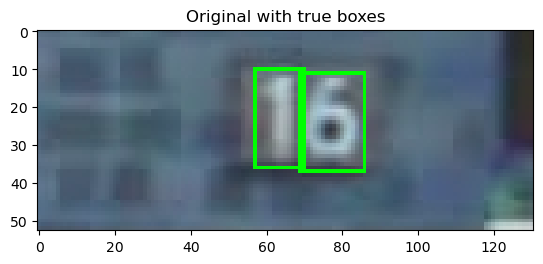

In [14]:
# choose random image from dataset
idx = random.randint(0, len(train_images_all)-1)
trialImage = train_images_all[idx].copy()
print("Picture number: ", idx+1)
print("Labels:")
plt.title("Original with true boxes")
imgBoxes = trialImage.copy()
for i in train_boxes_all[idx]:
    print(i['label'])
    cv2.rectangle(imgBoxes,
                  (int(i['left']),int(i['top'])),
                  (int(i['left'])+int(i['width']),int(i['top'])+int(i['height'])),
                  (0,255,0), 1)
plt.imshow(imgBoxes)
plt.show()


- Step 1: Bilateral filter smoothes all pic except edges

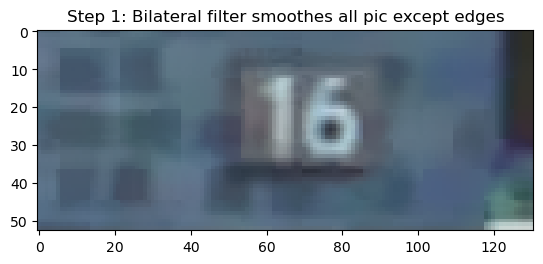

In [15]:
image = cv2.bilateralFilter(trialImage,11,7,7) 
plt.imshow(image)
plt.title("Step 1: Bilateral filter smoothes all pic except edges")
plt.show()

- Step 2: Convert to gray scale

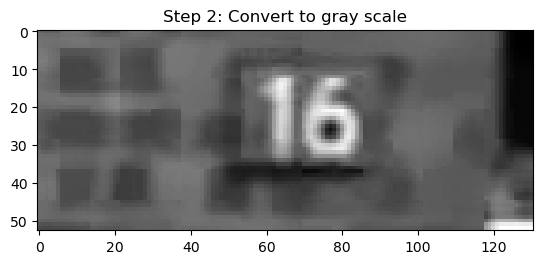

In [16]:
image = cv2.cvtColor(image.copy(),cv2.COLOR_BGR2GRAY)
plt.imshow(image, cmap='gray')
plt.title("Step 2: Convert to gray scale")
plt.show()

- Step 3: Enhance picture contrast

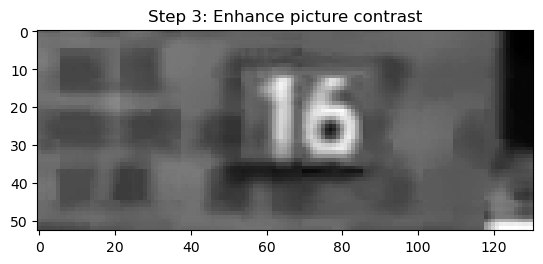

In [17]:
cv2.convertScaleAbs(image, image)
plt.imshow(image, cmap='gray')
plt.title("Step 3: Enhance picture contrast")
plt.show()

- Step 4: Apply adaptive thresholding

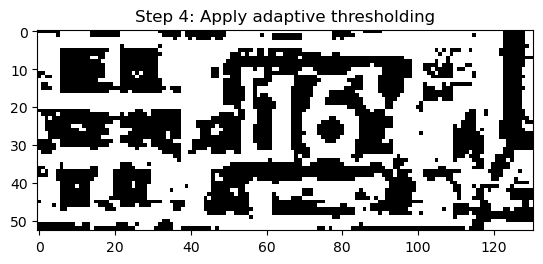

In [18]:
bnr = cv2.adaptiveThreshold(image,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,1)
plt.imshow(bnr, cmap='gray')
plt.title("Step 4: Apply adaptive thresholding")
plt.show()


- Step 5: (optional) Opening using 3x3 kernel

useOPEN =  1


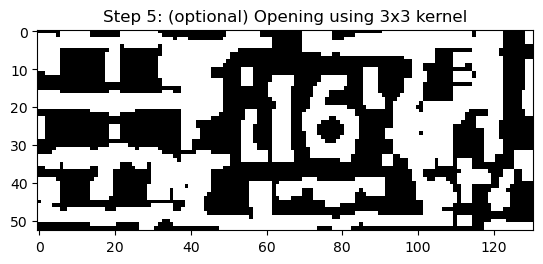

In [19]:
temp = useOPEN
useOPEN = 1 #configure here
kernel = np.ones((3, 3), np.uint8)
print("useOPEN = ", useOPEN)
if(useOPEN):
    bnr = cv2.morphologyEx(bnr, cv2.MORPH_OPEN,
                           kernel, iterations=1)
plt.imshow(bnr,cmap='gray')
plt.title("Step 5: (optional) Opening using 3x3 kernel")
plt.show()
useOPEN = temp

useCLOSE =  1


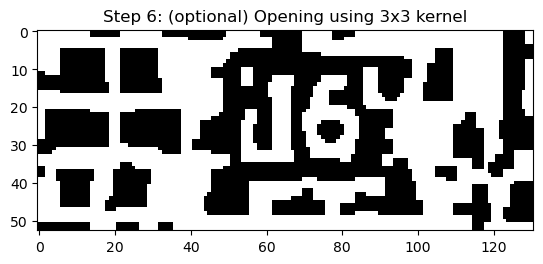

In [20]:
temp = useCLOSE
useCLOSE = 1 #configure here
print("useCLOSE = ",useCLOSE)
if(useCLOSE):
    bnr = cv2.morphologyEx(bnr, cv2.MORPH_CLOSE,
                           kernel, iterations=1)
plt.figure()
plt.imshow(bnr, cmap='gray')
plt.title("Step 6: (optional) Opening using 3x3 kernel")
plt.show()
useCLOSE = temp

- Step 7: (optional) Canny edge detection

Threshold1:  150
Threshold2:  200


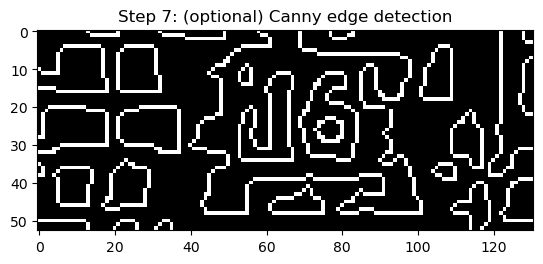

In [21]:
temp = useCANNY
useCANNY = 1 #configure here
if(useCANNY):
    print("Threshold1: ", cannyTH1)
    print("Threshold2: ", cannyTH2)
    bnr = cv2.Canny(bnr, cannyTH1, cannyTH2, 255)
plt.figure()
plt.imshow(bnr, cmap='gray')
plt.title("Step 7: (optional) Canny edge detection")
plt.show()
useCANNY = temp

- Step 8: Extract contours

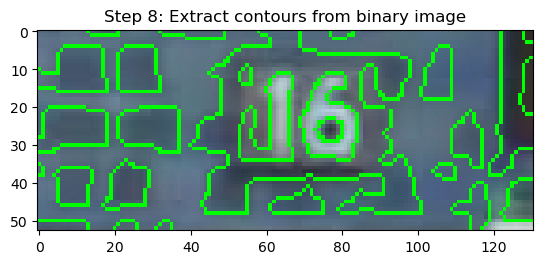

In [22]:
contours, hierarchy = cv2.findContours(bnr, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
temp = trialImage.copy()
cv2.drawContours(temp,contours,-1,color=(0,255,0),thickness=1)
plt.imshow(temp)
plt.title("Step 8: Extract contours from binary image")
plt.show()

- Step 9: Draw Rectangles around contours

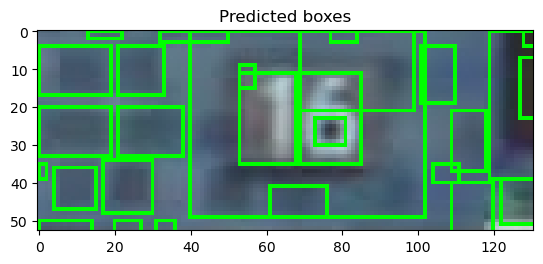

In [23]:
temp = trialImage.copy()
for i in range(len(contours)):    
        x,y,w,h = cv2.boundingRect(contours[i])
        cv2.rectangle(temp,
                  (x,y),
                  (x+w,y+h),
                  (0,255,0), 1)
plt.imshow(temp)
plt.title("Predicted boxes")
plt.show()

# Checking best bilateral sigma value as a hyperparameter

In [24]:
n = 1000
train_images = train_images_all
train_labels = train_labels_all
train_boxes = train_boxes_all

- Check values from 5 to 80, step 5 and plotting the results.

- Best accuracy value is between sigma value 10-25, repeat the test with step = 1 to find the exact value.

In [61]:
all_acc = []
mx = 0
idx = 0
for i in range(1, 25):
    acc, foundCount = getAllIOUAccuracy(train_images, train_boxes, i)
    all_acc.append(acc)
    if mx < acc:
        mx = acc
        idx = i
x = [i for i in range(1, 25)]
plt.plot(x, all_acc)
plt.title("Effect of Bilateral Sigma on Accuracy (Zoomed in)")
plt.ylabel("Accuracy(%)")
plt.xlabel("Bilateral Sigma")
plt.show()
print("Maximum Localization Accuracy obtained:",mx*100,"%")
print("At bilateral sigma =",idx)

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (24,) and (1,)

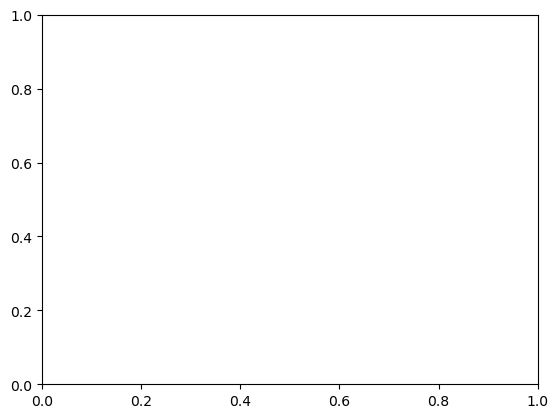

In [52]:
x = [i for i in range(1, 25)]
plt.plot(x, all_acc)
plt.title("Effect of Bilateral Sigma on Accuracy (Zoomed in)")
plt.ylabel("Accuracy(%)")
plt.xlabel("Bilateral Sigma")
plt.show()
print("Maximum Localization Accuracy obtained:",mx*100,"%")
print("At bilateral sigma =",idx)

In [54]:
idx

17

# Accuracy Testing Scnearios

### 1- Testing on a single random image

In [27]:
idx=random.randint(0, len(train_images_all)-1)
print("Filename:",idx+1)
print("True labels:",train_labels_all[idx])
predicted_boxes = rectanglesModel(train_images_all[idx])
true_boxes = train_boxes_all[idx]
accuracy, ret = (iouPicTest(true_boxes,predicted_boxes))
print("Localization Accuracy:",accuracy*100,"%")
print(len(ret),"out of", len(true_boxes), "true boxes found, Recall:", len(ret)*100/len(true_boxes),"%")

Filename: 12530
True labels: [1. 2. 6.]
Localization Accuracy: 23.079427083333336 %
1 out of 3 true boxes found, Recall: 33.333333333333336 %


### 2- Testing on a sample 1000 images

In [28]:
n = 1000
train_images = train_images_all[n:n+1000]
train_labels = train_labels_all[n:n+1000]
train_boxes = train_boxes_all[n:n+1000]

In [29]:
print(len(train_images), "pictures are under testing")
all_acc, foundCount = getAllIOUAccuracy(train_images, train_boxes)
print("Localization Accuracy: ", all_acc*100, "%")
print("Recall: ", foundCount*100/np.array(train_boxes).size, "%")

1000 pictures are under testing
Localization Accuracy:  42.584859212239586 %
Recall:  116.8 %


### 3- Testing on data groups split according to image size

- Split according to image size

In [30]:
n_groups = 3
res_indices = split_resolution(train_images_all, n_groups)
images_res_splitted, labels_res_splitted, boxes_res_splitted = split_dataset(res_indices,train_images_all, train_labels_all, train_boxes_all)

4356
4356
4356


In [31]:
len([item for sublist in boxes_res_splitted[0] for item in sublist])

8242

- Run localization algorithm, testing to find results.

In [59]:
accuracy_groups =[]
recall_groups = []
group_names = []

for i in range(n_groups):
    print("Group:",i+1)
    print(len(images_res_splitted[i]),"images.")
    all_acc, foundCount = getAllIOUAccuracy(images_res_splitted[i], boxes_res_splitted[i])
    print("Localization Accuracy: ", all_acc*100, "%")
    positives = len([item for sublist in boxes_res_splitted[i] for item in sublist])
    accuracy_groups.append(all_acc*100)
    truePositives = foundCount
    falseNegatives = positives - truePositives
    recall = truePositives*100/positives
    recall_groups.append(recall)
    group_names.append("Group "+str(i+1))
    print(truePositives,"out of", positives, "true boxes found, Recall:", recall ,"%")

Group: 1
4356 images.
Localization Accuracy:  46.619250178154644 %
5135 out of 8242 true boxes found, Recall: 62.30283911671924 %
Group: 2
4356 images.
Localization Accuracy:  45.06976895643222 %
5381 out of 8775 true boxes found, Recall: 61.32193732193732 %
Group: 3
4356 images.
Localization Accuracy:  37.673056432877544 %
4942 out of 9015 true boxes found, Recall: 54.819744869661676 %


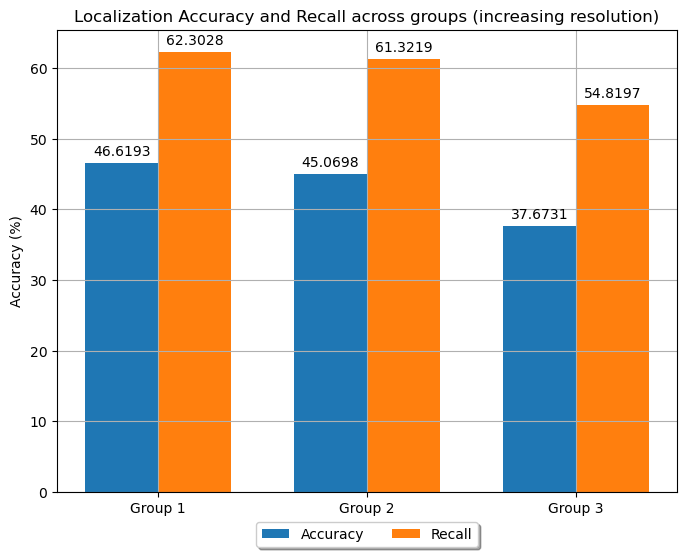

In [60]:
x = np.arange(len(group_names))
width = 0.35 
fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, accuracy_groups, width, label='Accuracy')
rects2 = ax.bar(x + width/2, recall_groups, width, label='Recall')

ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Group')
ax.set_xticks(x, group_names)
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title("Localization Accuracy and Recall across groups (increasing resolution)")
plt.grid()
plt.show()

- Visualize results:

### 4- Testing on data groups split according to numbers area to image size ratio

- Split according to numbers size in images

In [34]:
n_groups = 3
area_indices = split_boxes_area(train_images_all, train_boxes_all, n_groups)
images_area_splitted, labels_area_splitted, boxes_area_splitted = split_dataset(area_indices, train_images_all, train_boxes_all, train_labels_all)

4356
4356
4356


- Run localization algorithm, testing to find results.

In [35]:
accuracy_groups =[]
recall_groups = []
group_names = []
for i in range(n_groups):
    print("Group:",i+1)
    print(len(images_area_splitted[i]),"images.")
    all_acc, foundCount = getAllIOUAccuracy(images_area_splitted[i], boxes_area_splitted[i])
    print("Localization Accuracy: ", all_acc*100, "%")
    positives = len([item for sublist in boxes_area_splitted[i] for item in sublist])
    accuracy_groups.append(all_acc*100)
    truePositives = foundCount
    falseNegatives = positives - truePositives
    recall = truePositives*100/positives
    recall_groups.append(recall)
    group_names.append("Group "+str(i+1))
    print(truePositives,"out of", positives, "true boxes found, Recall:", recall ,"%")

Group: 1
4356 images.
Localization Accuracy:  38.971659249036286 %
4472 out of 8166 true boxes found, Recall: 54.76365417585109 %
Group: 2
4356 images.
Localization Accuracy:  44.76834178372264 %
5190 out of 8564 true boxes found, Recall: 60.60252218589444 %
Group: 3
4356 images.
Localization Accuracy:  46.016017515651306 %
5894 out of 9302 true boxes found, Recall: 63.36271769511933 %


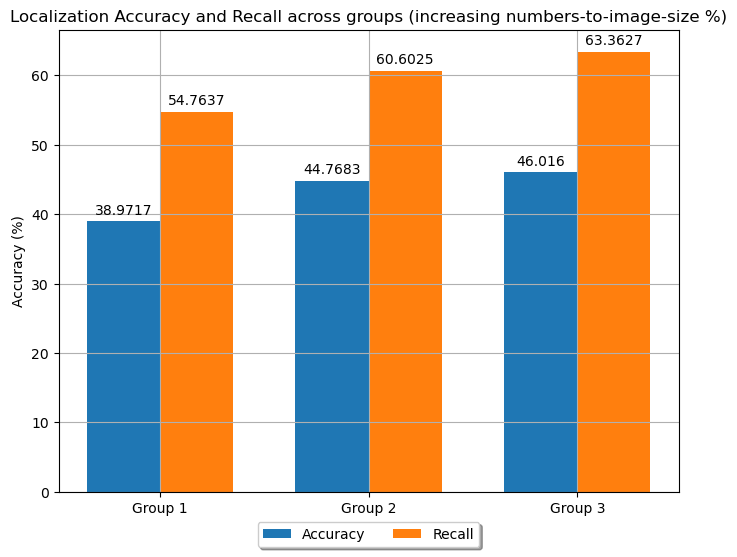

In [36]:
x = np.arange(len(group_names))
width = 0.35 
fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, accuracy_groups, width, label='Accuracy')
rects2 = ax.bar(x + width/2, recall_groups, width, label='Recall')

ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Group')
ax.set_xticks(x, group_names)
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title("Localization Accuracy and Recall across groups (increasing numbers-to-image-size %)")
plt.grid()
plt.show()

### 5- Testing on data groups split according to grayscale histogram weighted average (brightness).

- Split according to grayscale histogram weighted average (brightness)

In [37]:
n_groups = 3
hist_indices = split_histogram(train_images_all, n_groups)
images_hist_splitted, labels_hist_splitted, boxes_hist_splitted = split_dataset(hist_indices, train_images_all, train_boxes_all, train_labels_all)

4356
4356
4356


- Run localization algorithm, testing to find results.

In [38]:
accuracy_groups =[]
recall_groups = []
group_names = []
for i in range(n_groups):
    print("Group:",i+1)
    print(len(images_hist_splitted[i]),"images.")
    all_acc, foundCount = getAllIOUAccuracy(images_hist_splitted[i], boxes_hist_splitted[i])
    print("Localization Accuracy: ", all_acc*100, "%")
    positives = len([item for sublist in boxes_hist_splitted[i] for item in sublist])
    accuracy_groups.append(all_acc*100)
    truePositives = foundCount
    falseNegatives = positives - truePositives
    recall = truePositives*100/positives
    recall_groups.append(recall)
    group_names.append("Group "+str(i+1))
    print(truePositives,"out of", positives, "true boxes found, Recall:", recall ,"%")

Group: 1
4356 images.
Localization Accuracy:  38.86344468298037 %
4877 out of 8737 true boxes found, Recall: 55.82007554080348 %
Group: 2
4356 images.
Localization Accuracy:  42.97468630881495 %
5229 out of 8805 true boxes found, Recall: 59.38671209540034 %
Group: 3
4356 images.
Localization Accuracy:  47.917887556614915 %
5450 out of 8490 true boxes found, Recall: 64.19316843345112 %


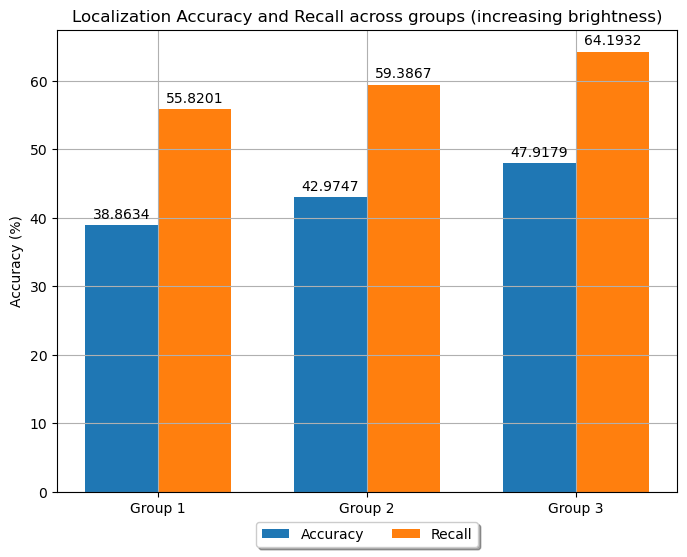

In [39]:
x = np.arange(len(group_names))
width = 0.35 
fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, accuracy_groups, width, label='Accuracy')
rects2 = ax.bar(x + width/2, recall_groups, width, label='Recall')

ax.set_ylabel('Accuracy (%)')
ax.set_xlabel('Group')
ax.set_xticks(x, group_names)
ax.legend()
ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)
plt.title("Localization Accuracy and Recall across groups (increasing brightness)")
plt.grid()
plt.show()

## Average accuracy of all pictures:

In [58]:
print(len(train_images_all),"images.")
all_acc, foundCount = getAllIOUAccuracy(train_images_all, train_boxes_all)
print("Localization Accuracy: ", all_acc*100, "%")
positives = len([item for sublist in train_boxes_all for item in sublist])
truePositives = foundCount
falseNegatives = positives - truePositives
print(truePositives,"out of", positives, "true boxes found, Recall:", truePositives*100/positives,"%")

13068 images.
Localization Accuracy:  43.12069185582147 %
15458 out of 26032 true boxes found, Recall: 59.380762138905965 %


------------------------------------------------------------------